In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import torchvision

from config import (
    IMAGE_DIMENSION_STL,
    EPOCHS_MAX,
    get_device,
    WEIGHT_DECAY,
)
from utils import download_stl10, get_data_loaders, print_model_summary

print(torch.__version__)
print(torchvision.__version__)


DEVICE: torch.device = get_device()

2.10.0+cu128
0.25.0+cu128
Using DEVICE: cuda


In [4]:
train_dataset, test_dataset = download_stl10(img_dimensions=IMAGE_DIMENSION_STL)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

STL-10 ready  train=5000  test=8000  channels=3

Dataset Statistics:
Training samples: 5000
Testing samples: 8000
Number of classes: 10
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [5]:
train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset, train_dataset=train_dataset, batch_size=64
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

DataLoader Information:
Train batches: 79
Test batches: 125


In [8]:
# No 3 branches, only RGB

from utils import set_seed
from models import HalkaNetRGBOnly
from config import LABEL_SMOOTHING, BranchType

set_seed()

model_rgb = HalkaNetRGBOnly(
    num_classes=len(class_names),
    rgb_stem_channels=38,
    tail_depth=1,
    skip_expansion={
        BranchType.RGB: 1,
    },
)

In [9]:
print_model_summary(model=model_rgb, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNetRGBOnly                               [1, 3, 64, 64]            [1, 10]                   --                        --
├─Sequential: 1-1                             [1, 3, 64, 64]            [1, 76, 16, 16]           --                        --
│    └─Conv2d: 2-1                            [1, 3, 64, 64]            [1, 38, 64, 64]           114                       466,944
│    └─BatchNorm2d: 2-2                       [1, 38, 64, 64]           [1, 38, 64, 64]           76                        76
│    └─ReLU: 2-3                              [1, 38, 64, 64]           [1, 38, 64, 64]           --                        --
│    └─DepthwiseSeparableConv: 2-4            [1, 38, 64, 64]           [1, 38, 32, 32]           --                        --
│    │    └─Sequential: 3-1                   [1, 38, 64, 64]           [1, 38, 32, 32]           4

In [10]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_rgb,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/ablation/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 55,346 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 17.72%  Loss: 2.2220
  Test   Acc: 16.10%  Loss: 2.2949
Best saved (Test Acc: 16.10%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 28.86%  Loss: 1.9899
  Test   Acc: 17.32%  Loss: 2.2437
Best saved (Test Acc: 17.32%)
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 33.74%  Loss: 1.8412
  Test   Acc: 18.79%  Loss: 2.2284
Best saved (Test Acc: 18.79%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 37.95%  Loss: 1.

Generating predictions for Confusion Matrix...


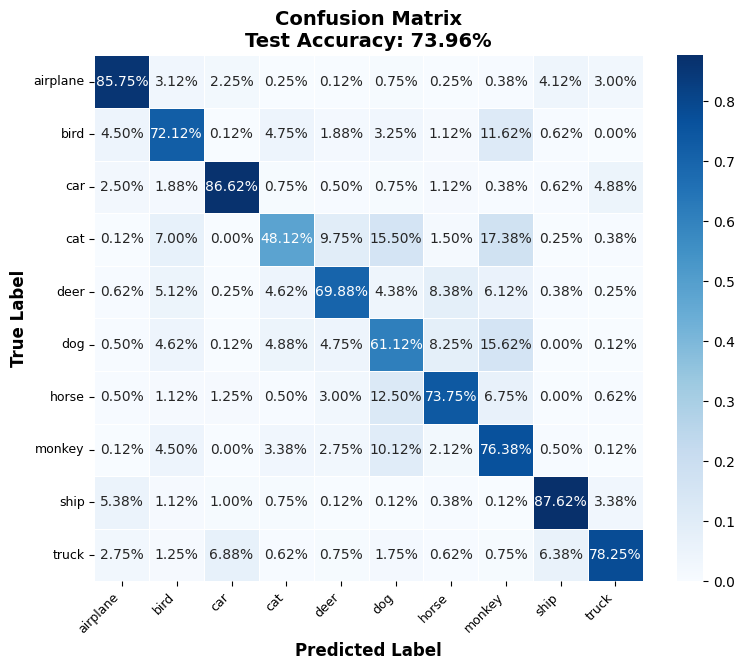


Most Confused Pairs (Errors > 10.00%):
  - True 'bird' predicted as 'monkey': 11.6%
  - True 'cat' predicted as 'dog': 15.5%
  - True 'cat' predicted as 'monkey': 17.4%
  - True 'dog' predicted as 'monkey': 15.6%
  - True 'horse' predicted as 'dog': 12.5%
  - True 'monkey' predicted as 'dog': 10.1%


In [11]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_rgb,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [12]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               73.96% 98.28%     55,346      19.8      0.22    1.87   534.5  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 73.96% Top-1 | 55,346 params | 1.87 ± 0.16 ms | 534.5 FPS



In [13]:
# Grayscale HalkaNet Ablation


from utils import set_seed
from models import HalkaNetGrayBranches
from config import LABEL_SMOOTHING, BranchType

set_seed()

model_gray = HalkaNetGrayBranches(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    tail_depth=1,
)

In [14]:
print_model_summary(model=model_gray, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNetGrayBranches                          [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                 [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                             [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                            [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                       [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                              [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseSeparableConv: 2-4            [1, 16, 64, 64]           [1, 16, 32, 32]        

In [15]:
from utils import run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_gray,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/ablation/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 46,570 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 16.18%  Loss: 2.2469
  Test   Acc: 10.78%  Loss: 2.3305
Best saved (Test Acc: 10.78%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 28.90%  Loss: 2.0073
  Test   Acc: 10.78%  Loss: 2.2898
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 33.50%  Loss: 1.8374
  Test   Acc: 13.01%  Loss: 2.2312
Best saved (Test Acc: 13.01%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 35.88%  Loss: 1.7971
  Test   Acc: 24.99%  Los

Generating predictions for Confusion Matrix...


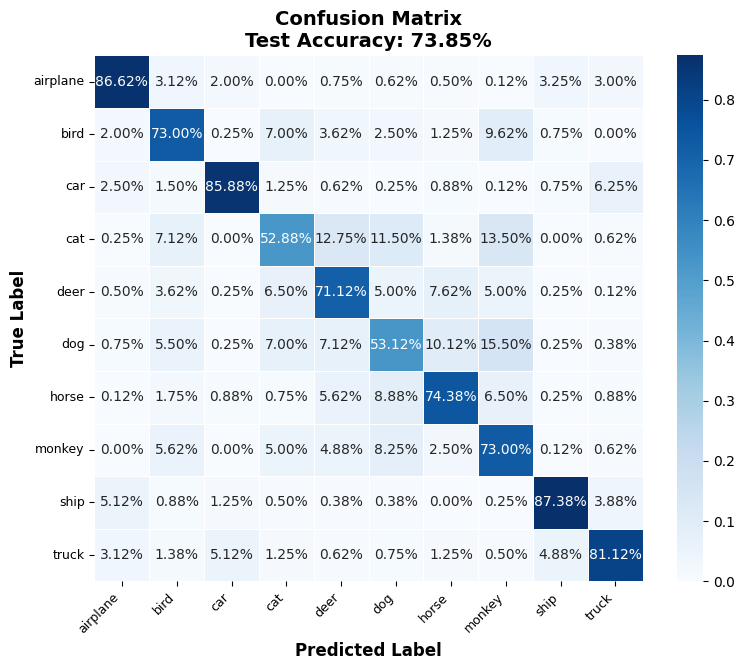


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'deer': 12.8%
  - True 'cat' predicted as 'dog': 11.5%
  - True 'cat' predicted as 'monkey': 13.5%
  - True 'dog' predicted as 'horse': 10.1%
  - True 'dog' predicted as 'monkey': 15.5%


In [16]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_gray,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [17]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               73.85% 98.46%     46,573      10.8      0.19    2.68   373.6  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 73.85% Top-1 | 46,573 params | 2.68 ± 0.46 ms | 373.6 FPS



In [ ]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

model_stl_train_1 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.GABOR, FilterType.WAVE],
    tail_depth=1,
)


In [6]:
print_model_summary(model=model_stl_train_1, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseConv: 2-4

In [7]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_1,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 46,912 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 20.67%  Loss: 2.2234
  Test   Acc: 10.75%  Loss: 2.3272
Best saved (Test Acc: 10.75%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 30.06%  Loss: 1.9619
  Test   Acc: 9.60%  Loss: 2.3066
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 36.17%  Loss: 1.8135
  Test   Acc: 14.76%  Loss: 2.2447
Best saved (Test Acc: 14.76%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 42.92%  Loss: 1.7162
  Test   Acc: 14.17%  Loss

In [8]:
tta_acc = evaluate_tta(
    model=model_stl_train_1, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.7603750228881836

Generating predictions for Confusion Matrix...


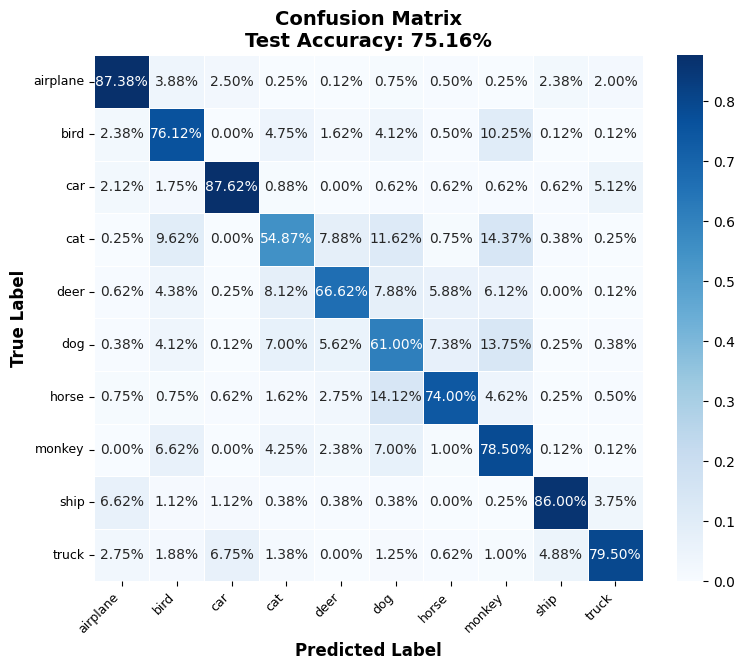


Most Confused Pairs (Errors > 10.00%):
  - True 'bird' predicted as 'monkey': 10.2%
  - True 'cat' predicted as 'dog': 11.6%
  - True 'cat' predicted as 'monkey': 14.4%
  - True 'dog' predicted as 'monkey': 13.8%
  - True 'horse' predicted as 'dog': 14.1%


In [9]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_1,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [ ]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               75.16% 98.52%     46,915      11.2      0.16    3.39   295.4  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 75.16% Top-1 | 46,915 params | 3.39 ± 0.20 ms | 295.4 FPS



Saved → ../figure/ablation/train_stl_1_64x64_47k.pdf / .png


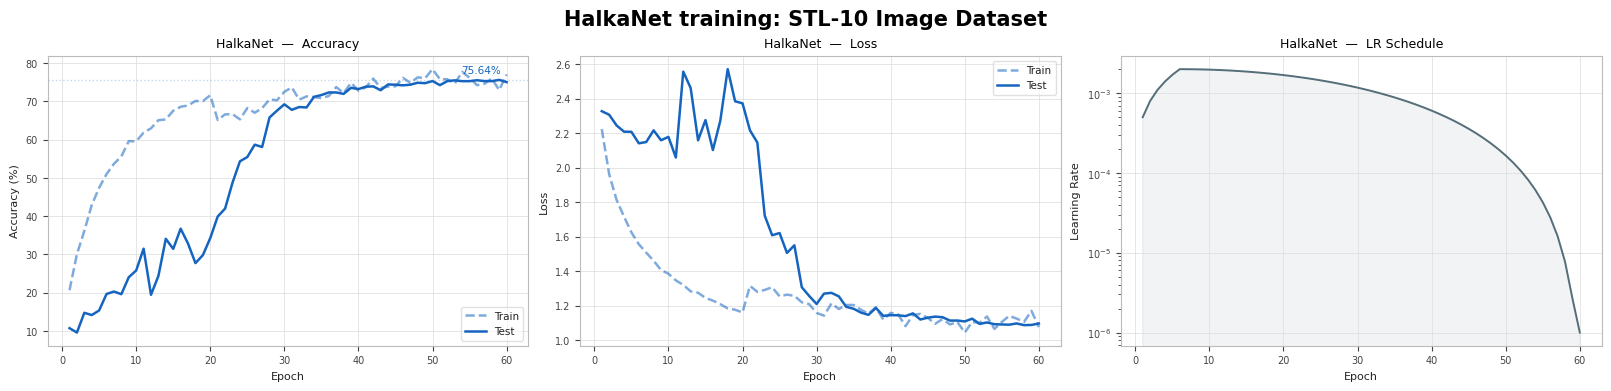

In [11]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/ablation/train_stl_1_64x64_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)

In [12]:
from utils import cleanup

cleanup(results, model_stl_train_1)

CUDA  Allocated 18.5 MB  Reserved 46.1 MB


In [13]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

# Low param 47.8k, 64x64

model_stl_train_2 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.GABOR],
    tail_depth=1,
)


In [14]:
print_model_summary(model=model_stl_train_2, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseConv: 2-4

In [15]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_2,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 46,884 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 18.43%  Loss: 2.2362
  Test   Acc: 10.90%  Loss: 2.3178
Best saved (Test Acc: 10.90%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 31.25%  Loss: 1.9659
  Test   Acc: 11.92%  Loss: 2.3249
Best saved (Test Acc: 11.92%)
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 37.05%  Loss: 1.8065
  Test   Acc: 14.96%  Loss: 2.2075
Best saved (Test Acc: 14.96%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 42.42%  Loss: 1.

Generating predictions for Confusion Matrix...


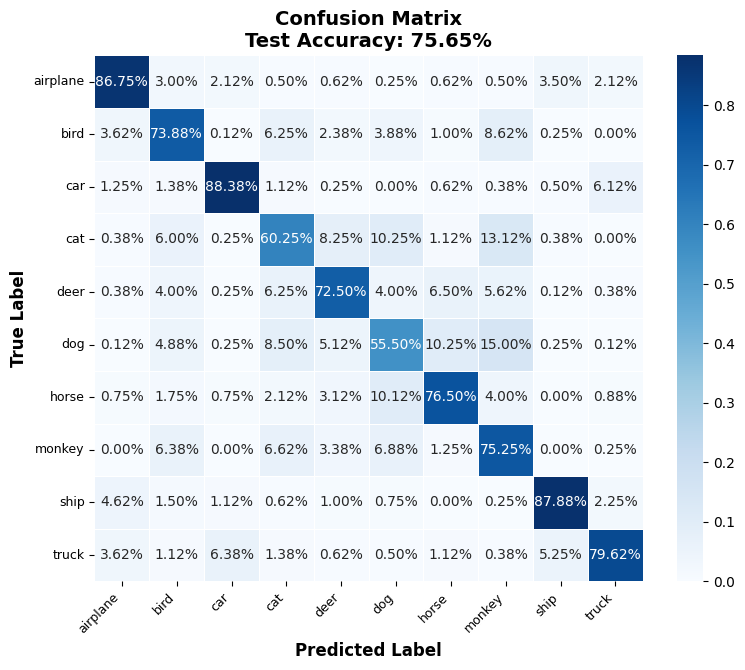


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'dog': 10.2%
  - True 'cat' predicted as 'monkey': 13.1%
  - True 'dog' predicted as 'horse': 10.2%
  - True 'dog' predicted as 'monkey': 15.0%
  - True 'horse' predicted as 'dog': 10.1%


In [16]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_2,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [17]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               75.65% 98.31%     46,887      11.1      0.16    3.40   294.2  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 75.65% Top-1 | 46,887 params | 3.40 ± 0.31 ms | 294.2 FPS



Saved → ../figure/ablation/train_stl_2_64x64_47k.pdf / .png


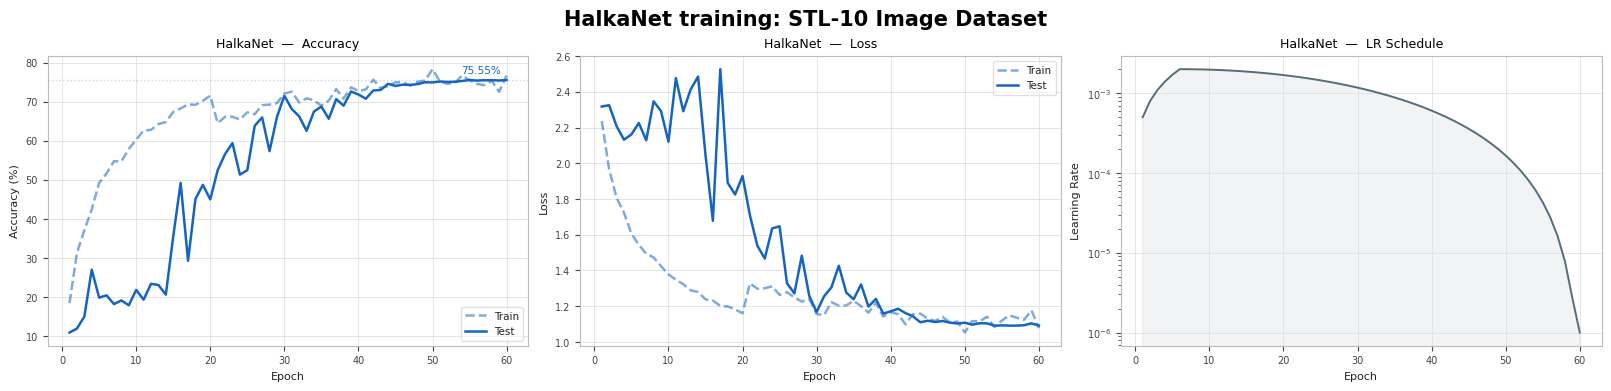

In [18]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/ablation/train_stl_2_64x64_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)

In [19]:
from utils import cleanup

cleanup(results, model_stl_train_2)


CUDA  Allocated 19.0 MB  Reserved 46.1 MB


In [20]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

# Low param 47.8k, 64x64

model_stl_train_3 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.WAVE],
    tail_depth=1,
)

In [21]:
print_model_summary(model=model_stl_train_3, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseConv: 2-4

In [22]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_3,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 46,884 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 18.67%  Loss: 2.2318
  Test   Acc: 10.36%  Loss: 2.3276
Best saved (Test Acc: 10.36%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 31.09%  Loss: 1.9601
  Test   Acc: 10.85%  Loss: 2.3547
Best saved (Test Acc: 10.85%)
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 37.42%  Loss: 1.7970
  Test   Acc: 11.10%  Loss: 2.2593
Best saved (Test Acc: 11.10%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 44.78%  Loss: 1.

Generating predictions for Confusion Matrix...


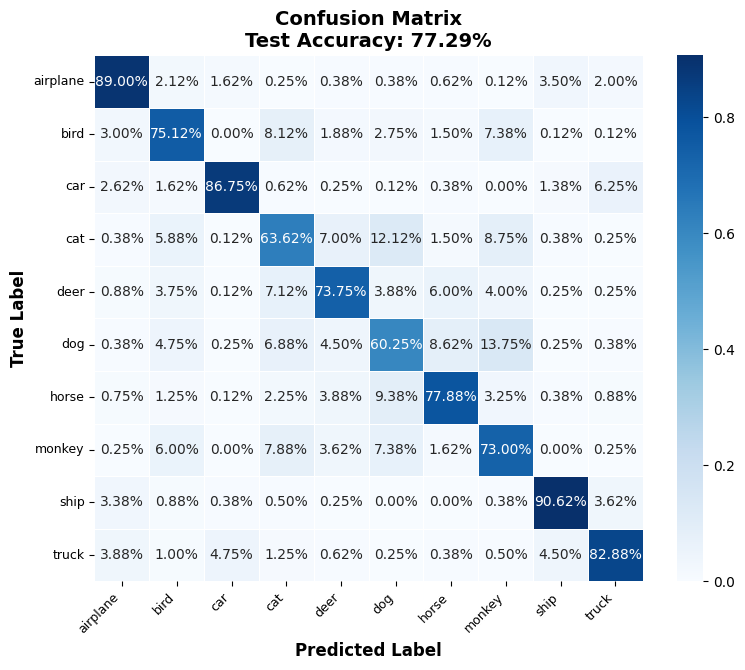


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'dog': 12.1%
  - True 'dog' predicted as 'monkey': 13.8%


In [23]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_3,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [24]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               77.29% 98.38%     46,887      11.1      0.16    3.67   272.3  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 77.29% Top-1 | 46,887 params | 3.67 ± 0.42 ms | 272.3 FPS



Saved → ../figure/ablation/train_stl_3_64x64_47k.pdf / .png


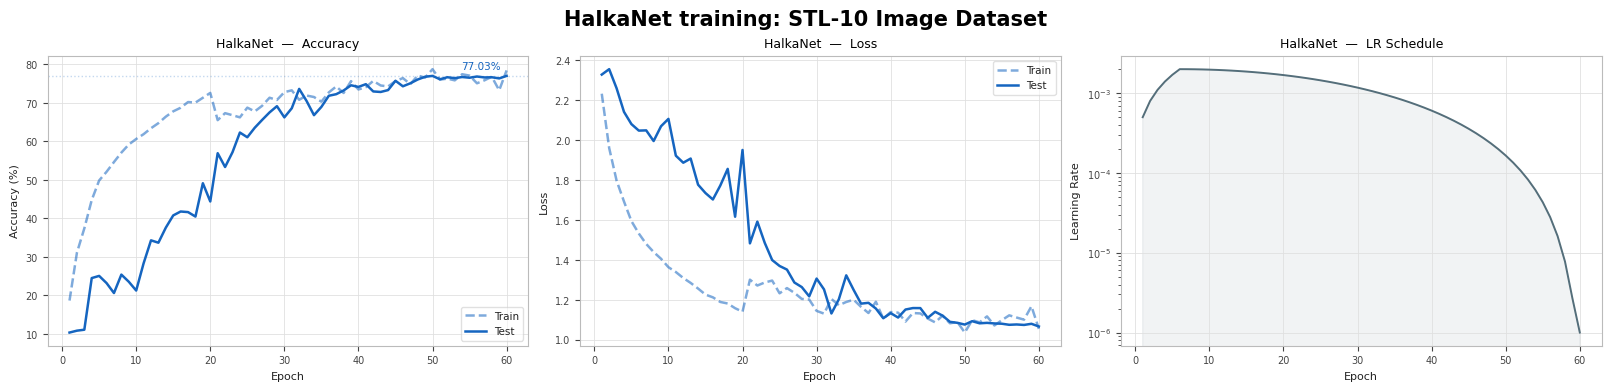

In [25]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/ablation/train_stl_3_64x64_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)

In [26]:
from utils import cleanup

cleanup(results, model_stl_train_3)


CUDA  Allocated 19.4 MB  Reserved 46.1 MB


In [27]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

# Low param 47.8k, 64x64

model_stl_train_4 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    filters=[FilterType.LOG],
    tail_depth=1,
)

In [28]:
print_model_summary(model=model_stl_train_4, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseConv: 2-4

In [29]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_4,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 46,828 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 18.02%  Loss: 2.2517
  Test   Acc: 10.25%  Loss: 2.3067
Best saved (Test Acc: 10.25%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 29.15%  Loss: 2.0022
  Test   Acc: 13.25%  Loss: 2.2975
Best saved (Test Acc: 13.25%)
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 35.96%  Loss: 1.8129
  Test   Acc: 15.61%  Loss: 2.2768
Best saved (Test Acc: 15.61%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 41.52%  Loss: 1.

Generating predictions for Confusion Matrix...


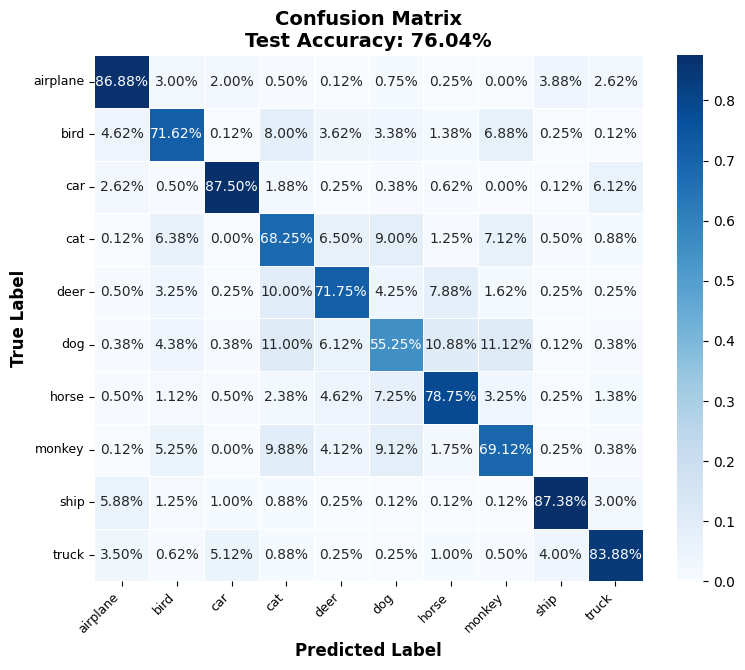


Most Confused Pairs (Errors > 10.00%):
  - True 'dog' predicted as 'cat': 11.0%
  - True 'dog' predicted as 'horse': 10.9%
  - True 'dog' predicted as 'monkey': 11.1%


In [30]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_4,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [31]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               76.04% 98.55%     46,831      10.9      0.16    3.61   277.4  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 76.04% Top-1 | 46,831 params | 3.61 ± 0.26 ms | 277.4 FPS



Saved → ../figure/ablation/train_stl_4_64x64_47k.pdf / .png


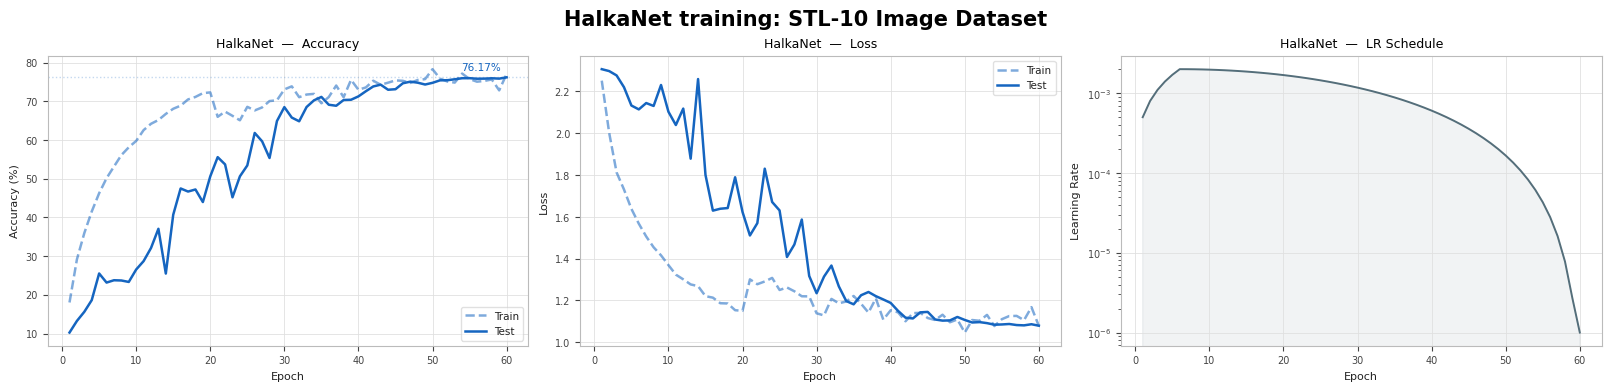

In [32]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/ablation/train_stl_4_64x64_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)

In [33]:
from utils import cleanup

cleanup(results, model_stl_train_4)


CUDA  Allocated 19.8 MB  Reserved 46.1 MB


In [34]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

# Low param 47.8k, 64x64

model_stl_train_5 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    filters=[FilterType.LBP],
    tail_depth=1,
)

In [35]:
print_model_summary(model=model_stl_train_5, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseConv: 2-4

In [36]:
from utils import run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_5,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 46,828 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 19.42%  Loss: 2.2385
  Test   Acc: 11.22%  Loss: 2.3017
Best saved (Test Acc: 11.22%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 30.52%  Loss: 1.9541
  Test   Acc: 16.80%  Loss: 2.2836
Best saved (Test Acc: 16.80%)
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 36.87%  Loss: 1.7982
  Test   Acc: 20.85%  Loss: 2.2438
Best saved (Test Acc: 20.85%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 42.52%  Loss: 1.

Generating predictions for Confusion Matrix...


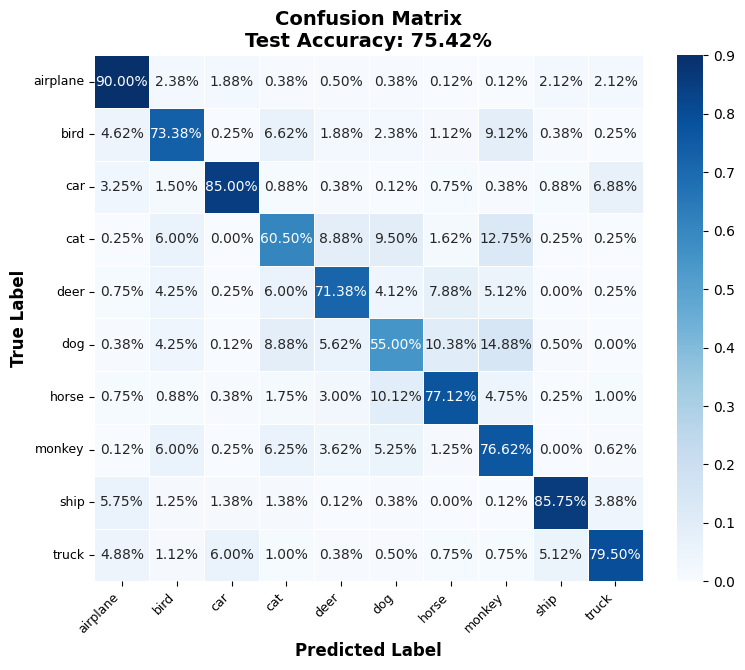


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'monkey': 12.8%
  - True 'dog' predicted as 'horse': 10.4%
  - True 'dog' predicted as 'monkey': 14.9%
  - True 'horse' predicted as 'dog': 10.1%


In [37]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_5,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [38]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               75.42% 98.36%     46,831      10.9      0.16    3.22   310.6  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 75.42% Top-1 | 46,831 params | 3.22 ± 0.36 ms | 310.6 FPS



Saved → ../figure/ablation/train_stl_5_64x64_47k.pdf / .png


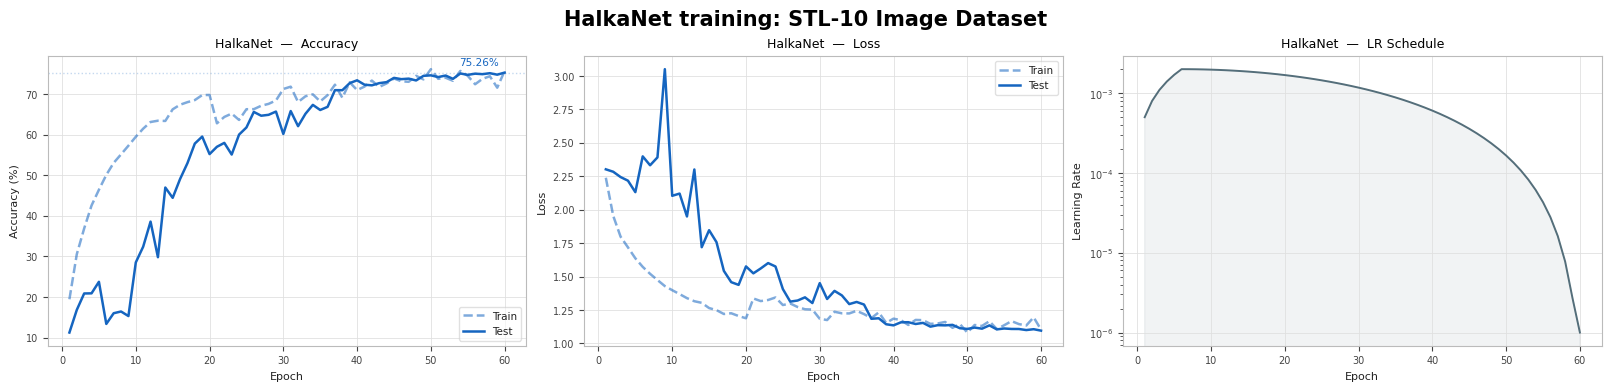

In [39]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/ablation/train_stl_5_64x64_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)

In [40]:
from utils import cleanup

cleanup(results, model_stl_train_5)


CUDA  Allocated 20.2 MB  Reserved 46.1 MB


In [41]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

# Low param 47.8k, 64x64

model_stl_train_6 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=12,
    tail_depth=1,
)

In [42]:
print_model_summary(model=model_stl_train_6, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseConv: 2-4

In [43]:
from utils import run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_stl_train_6,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/stl_64x64_model_47k",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 46,800 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 6 epochs → peak 2e-03 | Cosine: 54 epochs → 2.7e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 5.00e-04
  Epoch   3: 8.00e-04
  Epoch   4: 1.10e-03
  Epoch   7: 2.00e-03
  Epoch  58: 1.62e-05
  Epoch  59: 7.76e-06
  Epoch  60: 2.69e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 60 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→60)

Epoch   1/60 | LR: 0.00050
  Train  Acc: 19.34%  Loss: 2.2340
  Test   Acc: 10.00%  Loss: 2.3206
Best saved (Test Acc: 10.00%)
-----------------------------------
Epoch   2/60 | LR: 0.00080
  Train  Acc: 30.10%  Loss: 2.0131
  Test   Acc: 10.60%  Loss: 2.2903
Best saved (Test Acc: 10.60%)
-----------------------------------
Epoch   3/60 | LR: 0.00110
  Train  Acc: 35.72%  Loss: 1.8128
  Test   Acc: 17.46%  Loss: 2.2385
Best saved (Test Acc: 17.46%)
-----------------------------------
Epoch   4/60 | LR: 0.00140
  Train  Acc: 44.48%  Loss: 1.

Generating predictions for Confusion Matrix...


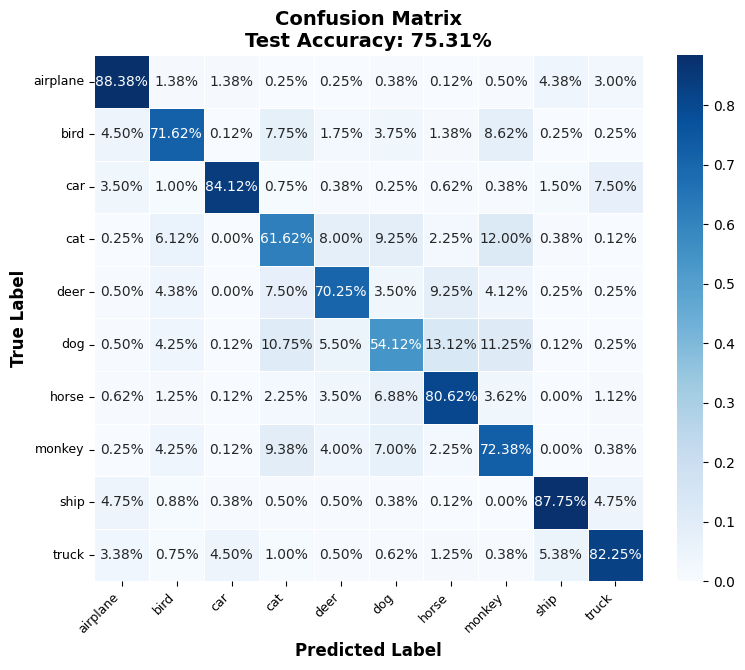


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'monkey': 12.0%
  - True 'dog' predicted as 'cat': 10.8%
  - True 'dog' predicted as 'horse': 13.1%
  - True 'dog' predicted as 'monkey': 11.2%


In [44]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_stl_train_6,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [45]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               75.31% 98.44%     46,803      10.8      0.16    3.10   322.9  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 75.31% Top-1 | 46,803 params | 3.10 ± 0.29 ms | 322.9 FPS



Saved → ../figure/ablation/train_stl_6_64x64_47k.pdf / .png


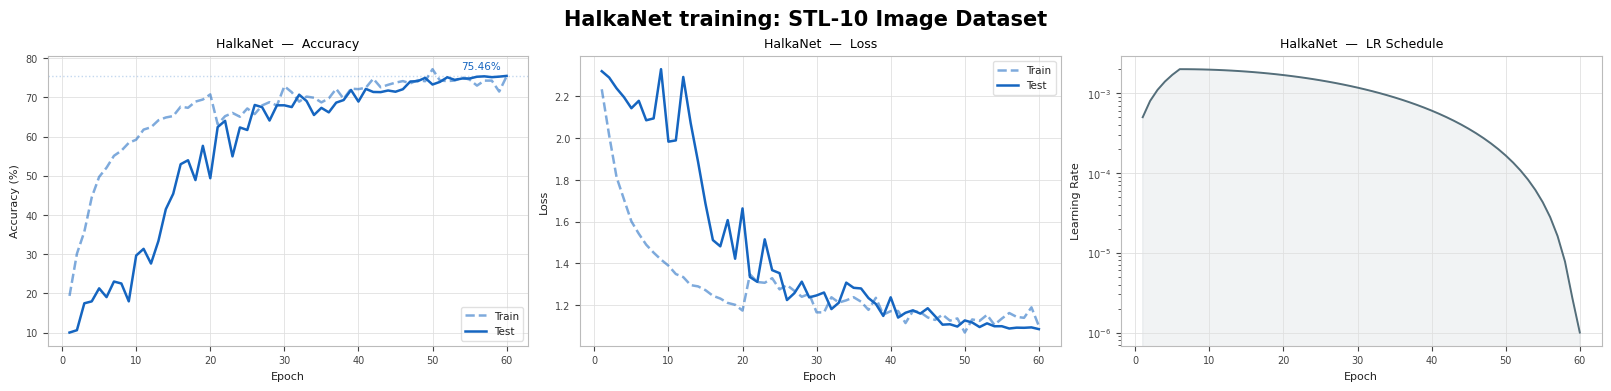

In [46]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/ablation/train_stl_6_64x64_47k.pdf",
    dataset_name="STL-10 Image Dataset",
    title="HalkaNet training:",
)

In [47]:
from utils import cleanup

cleanup(results, model_stl_train_6)

CUDA  Allocated 20.7 MB  Reserved 48.2 MB


In [3]:
from utils import download_cifar10
from config import IMAGE_DIMENSION_CIFAR, BATCH_SIZE

In [4]:
train_dataset, test_dataset = download_cifar10(img_dimensions=IMAGE_DIMENSION_CIFAR)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


CIFAR-10 ready  train=50000  test=10000  channels=3

Dataset Statistics:
Training samples: 50000
Testing samples: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset, train_dataset=train_dataset, batch_size=BATCH_SIZE
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 782
Test batches: 157


In [8]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

model_cifar_train_1 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1},
    filter_channels=14,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.WAVE],
    tail_depth=1,
)

In [9]:
print_model_summary(model=model_cifar_train_1, img_dim=IMAGE_DIMENSION_CIFAR)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                                       [1, 3, 32, 32]            [1, 40, 8, 8]             --                        --
│    └─Conv2d: 2-1                                      [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                                 [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseConv: 2-4  

In [10]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR, EPOCHS_PRO_MAX

results = run_experiment(
    halkanet=model_cifar_train_1,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/cifar10_1",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 66,477 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00064
  Train  Acc: 41.60%  Loss: 1.7527
  Test   Acc: 13.74%  Loss: 2.4365
Best saved (Test Acc: 13.74%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 57.68%  Loss: 1.4348
  Test   Acc: 10.39%  Loss: 2.5237
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 64.54%  Loss: 1.2968
  Test   Acc: 13.92%  Loss: 2.3561
Best saved (Test Acc: 13.92%)
-----------------------------------
Epoch   4/100 | LR: 0.00165
  Train  Acc: 67.77%  Loss: 1.

Generating predictions for Confusion Matrix...


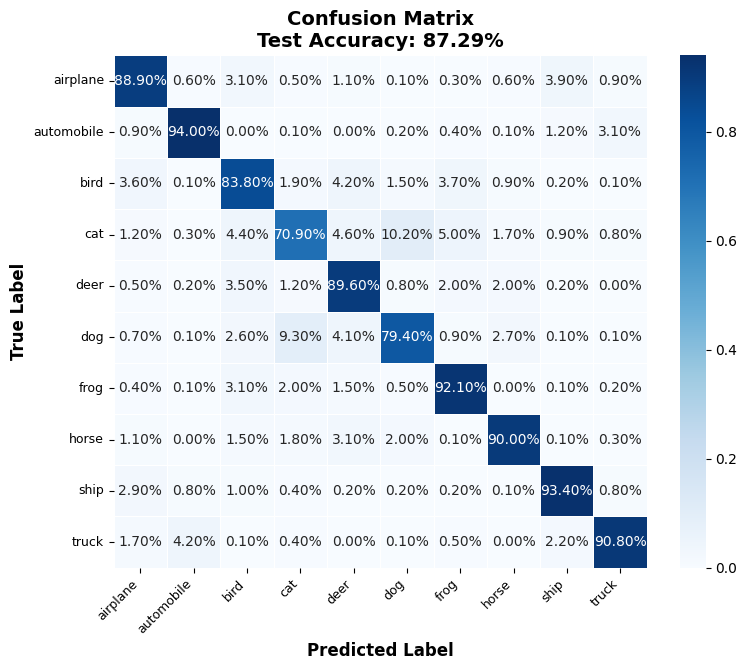


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'dog': 10.2%


In [11]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_cifar_train_1,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [12]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               87.29% 99.46%     66,480       3.9      0.23    3.30   303.3  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 87.29% Top-1 | 66,480 params | 3.30 ± 0.35 ms | 303.3 FPS



Saved → ../figure/ablation/train_cifar1-_1.pdf / .png


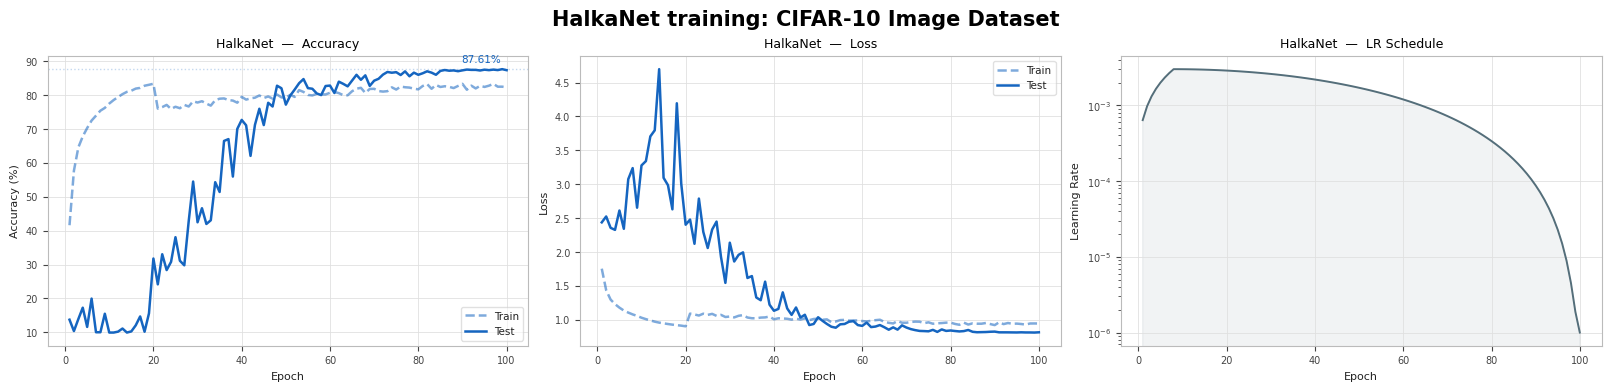

In [13]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/ablation/train_cifar1-_1.pdf",
    dataset_name="CIFAR-10 Image Dataset",
    title="HalkaNet training:",
)

In [6]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

model_cifar_train_2 = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1},
    filter_channels=14,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.GABOR],
    tail_depth=1,
)


In [7]:
print_model_summary(model=model_cifar_train_2, img_dim=IMAGE_DIMENSION_CIFAR)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                      [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                                 [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                             [1, 3, 32, 32]            [1, 40, 8, 8]             --                        --
│    └─Conv2d: 2-1                            [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                       [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                              [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseSeparableConv: 2-4            [1, 16, 32, 32]           [1, 16, 16, 16]          

In [10]:
from utils import run_experiment
from config import CHECKPOINT_DIR, EPOCHS_PRO_MAX

results = run_experiment(
    halkanet=model_cifar_train_2,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/cifar10_2",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 66,206 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00064
  Train  Acc: 40.42%  Loss: 1.7782
  Test   Acc: 10.33%  Loss: 2.3725
Best saved (Test Acc: 10.33%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 56.13%  Loss: 1.4688
  Test   Acc: 10.87%  Loss: 2.3585
Best saved (Test Acc: 10.87%)
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 62.47%  Loss: 1.3323
  Test   Acc: 18.03%  Loss: 2.3174
Best saved (Test Acc: 18.03%)
-----------------------------------
Epoch   4/100 | LR: 0.00165


Generating predictions for Confusion Matrix...


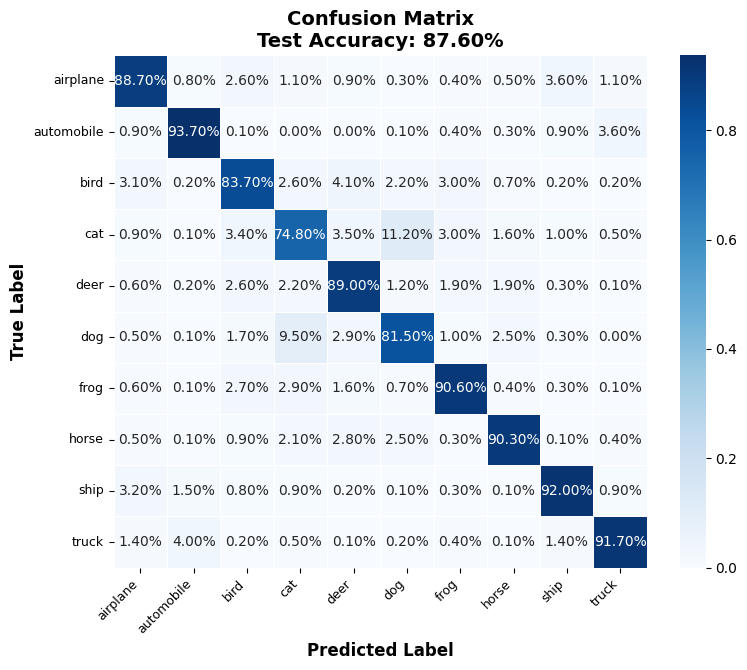


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'dog': 11.2%


In [11]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_cifar_train_2,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [12]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               87.60% 99.48%     66,209       4.0      0.26    3.50   285.7  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 87.60% Top-1 | 66,209 params | 3.50 ± 0.71 ms | 285.7 FPS

